Are G and H isomorphic? True


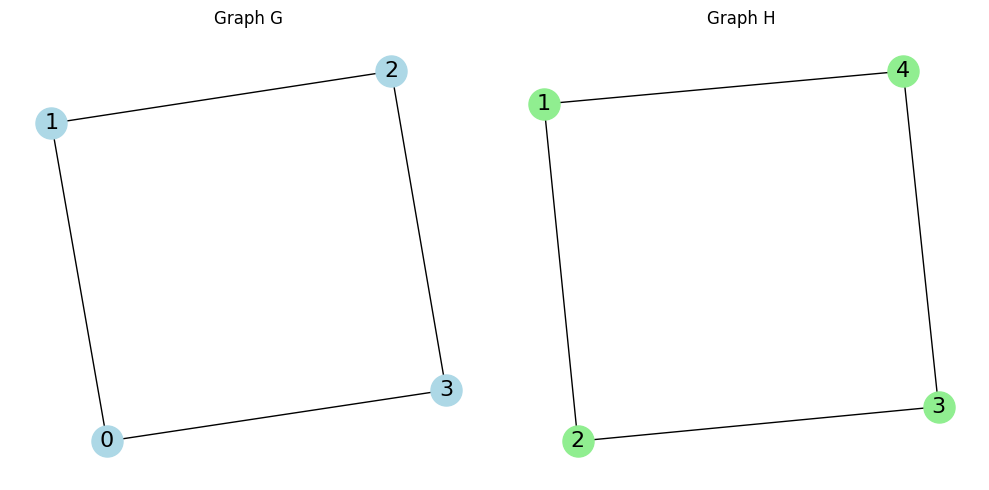

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create two isomorphic graphs
G = nx.Graph([(0,1), (1,2), (2,3), (3,0)])
H = nx.Graph([(1,2), (2,3), (3,4), (4,1)])

# Check if they are isomorphic
print(f"Are G and H isomorphic? {nx.is_isomorphic(G, H)}")

# Visualize the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

pos_G = nx.spring_layout(G)
nx.draw(G, pos_G, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=16, ax=ax1)
ax1.set_title("Graph G")

pos_H = nx.spring_layout(H)
nx.draw(H, pos_H, with_labels=True, node_color='lightgreen', 
        node_size=500, font_size=16, ax=ax2)
ax2.set_title("Graph H")

plt.tight_layout()
plt.show()

# Output: Are G and H isomorphic? True

[(0, 1), (1, 2), (2, 3)]


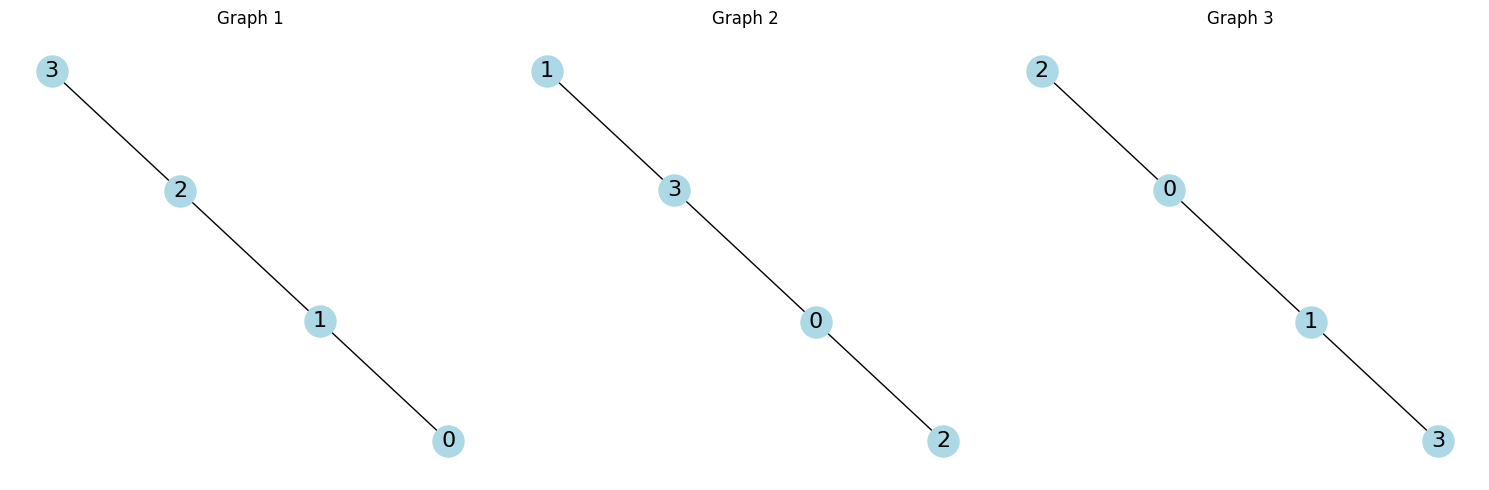

Generated and displayed 3 isomorphic graphs with 4 nodes each
Graph 0 and Graph 1 are isomorphic: True
Graph 0 and Graph 2 are isomorphic: True


In [126]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import math

def generate_isomorphic_graphs(num_graphs, num_nodes, is_cycle=False, seed=None):
    if num_nodes < 3:
        raise ValueError("Number of nodes should be at least 3 for non-trivial graphs")
    
    # Create a base graph
    base_graph = nx.Graph()
    base_graph.add_nodes_from(range(num_nodes))

     # Create a cycle, the cycle must be between the first and the N-1 node



    # Add edges that do not form a cycle until number of edges is N-1 nodes
    if is_cycle:
        edges = [(i, (i+1) % (num_nodes-1)) for i in range(num_nodes)]
    else:
        edges = [(i, i+1) for i in range(num_nodes-1)]

    print(edges)
    
    base_graph.add_edges_from(edges)

    isomorphic_graphs = [base_graph]
    
    for _ in range(num_graphs - 1):
        # Create a new graph with relabeled nodes
        new_labels = list(range(num_nodes))
        random.shuffle(new_labels)
        mapping = dict(zip(base_graph.nodes(), new_labels))
        new_graph = nx.relabel_nodes(base_graph, mapping)
        
        isomorphic_graphs.append(new_graph)
    
    # Visualize the graphs
    fig, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
    if num_graphs == 1:
        axes = [axes]
    
    for i, graph in enumerate(isomorphic_graphs):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, ax=axes[i], with_labels=True, node_color='lightblue', 
                node_size=500, font_size=16)
        axes[i].set_title(f"Graph {i+1}")
    
    plt.tight_layout()
    plt.show()
    
    return isomorphic_graphs

# Example usage
num_graphs = 3
num_nodes = 4

try:
    result = generate_isomorphic_graphs(num_graphs, num_nodes, is_cycle=False)
    print(f"Generated and displayed {len(result)} isomorphic graphs with {num_nodes} nodes each")
    
    # Verify isomorphism
    for i in range(1, len(result)):
        print(f"Graph 0 and Graph {i} are isomorphic: {nx.is_isomorphic(result[0], result[i])}")
except ValueError as e:
    print(f"Error: {e}")

[(0, 1), (1, 2), (2, 3)]


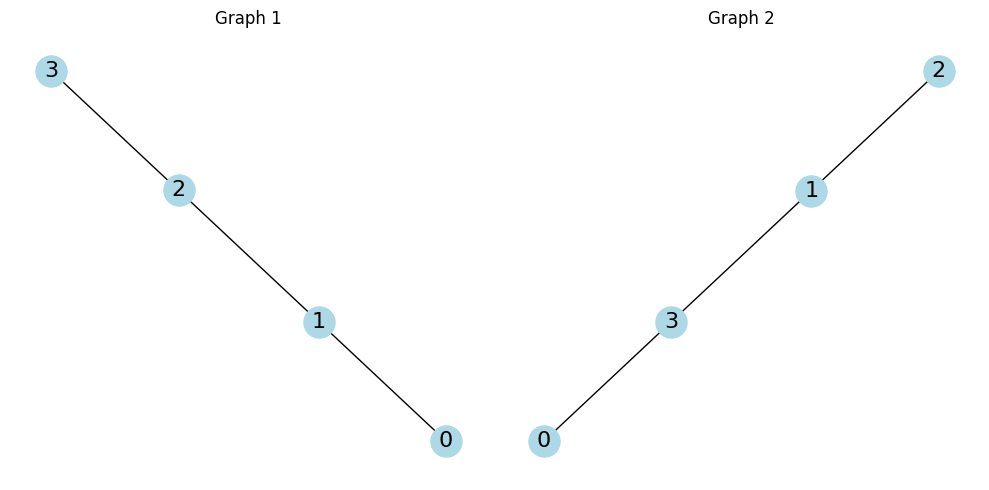

Graph with 3 edges has 6 permutations
Graph with 3 edges has 6 permutations
Generated permutations for 2 isomorphic graphs


In [103]:
def generate_edge_permutations(graph):
    edges = list(graph.edges())
    permutations = list(itertools.permutations(edges))
    
    permuted_graphs = []
    for perm in permutations:
        new_graph = nx.Graph()
        new_graph.add_nodes_from(graph.nodes())
        new_graph.add_edges_from(perm)
        permuted_graphs.append(new_graph)
    
    return permuted_graphs

def generate_and_permute_isomorphic_graphs(num_graphs, num_nodes):
    isomorphic_graphs = generate_isomorphic_graphs(num_graphs, num_nodes)
    all_permutations = []
    
    for graph in isomorphic_graphs:
        permutations = generate_edge_permutations(graph)
        all_permutations.append(permutations)
        
        num_edges = graph.number_of_edges()
        num_permutations = math.factorial(num_edges)
        print(f"Graph with {num_edges} edges has {num_permutations} permutations")
    
    return all_permutations

# Example usage
num_graphs = 2
num_nodes = 4

result = generate_and_permute_isomorphic_graphs(num_graphs, num_nodes)
print(f"Generated permutations for {num_graphs} isomorphic graphs")

0 2
Edges:
(0, 1)
(0, 2)
(1, 3)
(1, 2)
(3, 4)
Cycle:
[1, 2, 0]
Graph with 5 edges has 120 permutations
Graph with 5 edges has 120 permutations
Generated permutations for 2 isomorphic graphs, there are 240 graphs
Graph 1, Isomorphic Version 1: True
Graph 1, Isomorphic Version 2: True
Graph 1, Isomorphic Version 3: True
Graph 1, Isomorphic Version 4: True
Graph 1, Isomorphic Version 5: True
Graph 1, Isomorphic Version 6: True
Graph 1, Isomorphic Version 7: True
Graph 1, Isomorphic Version 8: True
Graph 1, Isomorphic Version 9: True
Graph 1, Isomorphic Version 10: True
Graph 1, Isomorphic Version 11: True
Graph 1, Isomorphic Version 12: True
Graph 1, Isomorphic Version 13: True
Graph 1, Isomorphic Version 14: True
Graph 1, Isomorphic Version 15: True
Graph 1, Isomorphic Version 16: True
Graph 1, Isomorphic Version 17: True
Graph 1, Isomorphic Version 18: True
Graph 1, Isomorphic Version 19: True
Graph 1, Isomorphic Version 20: True
Graph 1, Isomorphic Version 21: True
Graph 1, Isomorphic 

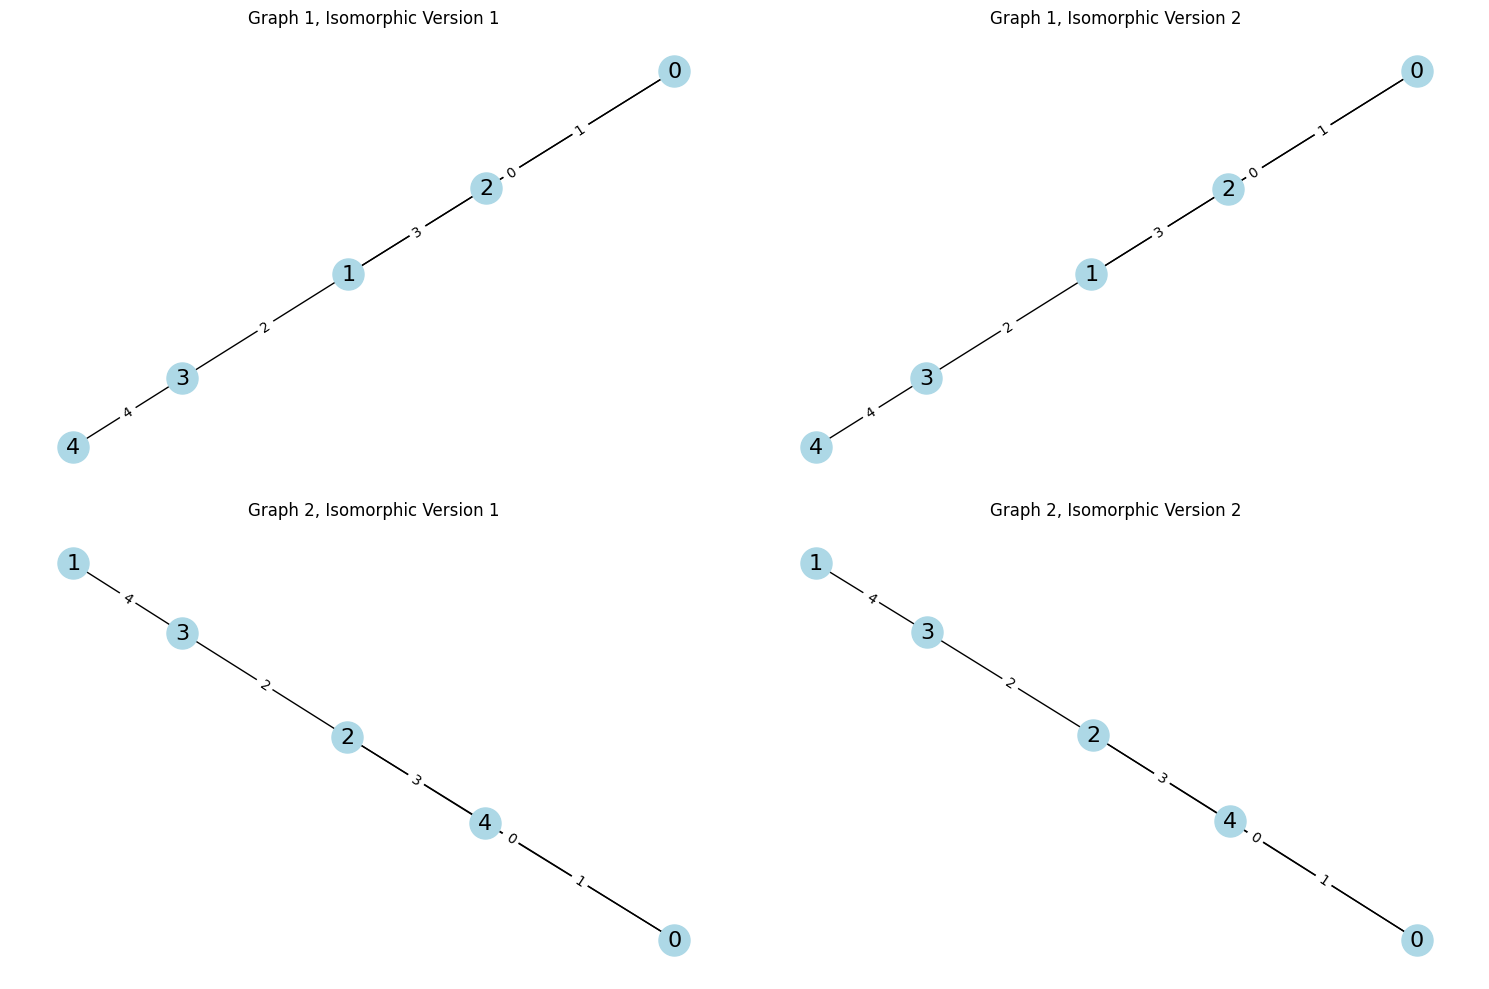

In [394]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import math

def generate_graph(num_nodes, allow_one_cycle=False):
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))

    # Ensure all nodes are connected
    for i in range(1, num_nodes):
        parent = random.randint(0, i-1)
        graph.add_edge(parent, i)

    # For any 2 degrees node, add an edge between the other 2 nodes that are connecting to it
    if allow_one_cycle:
        for node in graph.nodes():
            print(node, graph.degree(node))
            if graph.degree(node) >= 2:
                neighbors = list(graph.neighbors(node))
                graph.add_edge(neighbors[0], neighbors[1])
                break

    # # For each edge in the graph print the pair of nodes
    print("Edges:")
    for edge in graph.edges():
        print(edge)

    # print the nodes that form the cycle
    if allow_one_cycle:
        print("Cycle:")
        for cycle in nx.cycle_basis(graph):
            print(cycle)


    return graph

def generate_isomorphic_graphs(num_graphs, num_nodes, allow_one_cycle=False):
    base_graph = generate_graph(num_nodes, allow_one_cycle)
    isomorphic_graphs = [base_graph]

    for _ in range(num_graphs - 1):
        new_labels = list(range(num_nodes))
        random.shuffle(new_labels)
        mapping = dict(zip(base_graph.nodes(), new_labels))
        new_graph = nx.relabel_nodes(base_graph.copy(), mapping)
        isomorphic_graphs.append(new_graph)
    
    return isomorphic_graphs

def minimize_edge_labels(graph):
    edges = list(graph.edges())
    min_label = 0
    label_map = {}
    
    for edge in edges:
        if edge not in label_map and (edge[1], edge[0]) not in label_map:
            label_map[edge] = min_label
            min_label += 1
    
    new_graph = nx.Graph()
    new_graph.add_nodes_from(graph.nodes())
    for edge, label in label_map.items():
        new_graph.add_edge(edge[0], edge[1], weight=label)
    
    return new_graph

def generate_edge_permutations(graph):
    edges = list(graph.edges(data='weight'))
    permutations = list(itertools.permutations(edges))
    
    permuted_graphs = []
    for perm in permutations:
        new_graph = nx.Graph()
        new_graph.add_nodes_from(graph.nodes())
        for edge in perm:
            new_graph.add_edge(edge[0], edge[1], weight=edge[2])
        permuted_graphs.append(new_graph)
    
    return permuted_graphs

def generate_and_permute_isomorphic_graphs(num_graphs, num_nodes, allow_one_cycle=False):
    isomorphic_graphs = generate_isomorphic_graphs(num_graphs, num_nodes, allow_one_cycle)
    all_permutations = []
    
    for graph in isomorphic_graphs:
        minimized_graph = minimize_edge_labels(graph)
        permutations = generate_edge_permutations(minimized_graph)
        all_permutations.append(permutations)
        
        num_edges = graph.number_of_edges()
        num_permutations = math.factorial(num_edges)
        print(f"Graph with {num_edges} edges has {num_permutations} permutations")
    
    return all_permutations

def visualize_graph_with_edge_labels(graph, ax):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, ax=ax, with_labels=True, node_color='lightblue', node_size=500, font_size=16)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax)

# Example usage
num_graphs = 2
num_nodes = 5
allow_one_cycle = True

result = generate_and_permute_isomorphic_graphs(num_graphs, num_nodes, allow_one_cycle)
print(f"Generated permutations for {num_graphs} isomorphic graphs, there are {len(result[0]) + len(result[1])} graphs")

# Check for isomorphism for each pair of graphs in each result, result[0] have the permutations of the first graph and result[1] have the permutations of the second graph
for i, permutations in enumerate(result):
    for j in range(len(permutations)):
        print(f"Graph {i+1}, Isomorphic Version {j+1}: {nx.is_isomorphic(result[i][0], permutations[j])}")

# Visualize the graphs in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, permutations in enumerate(result):
    for j in range(2):
        visualize_graph_with_edge_labels(permutations[j], axes[i, j])
        axes[i, j].set_title(f"Graph {i+1}, Isomorphic Version {j+1}")

plt.tight_layout()
plt.show()

Adding edge between 0 and 3
Cycle:
[2, 3, 0]
Generated 18 non-isomorphic graphs from edge permutations


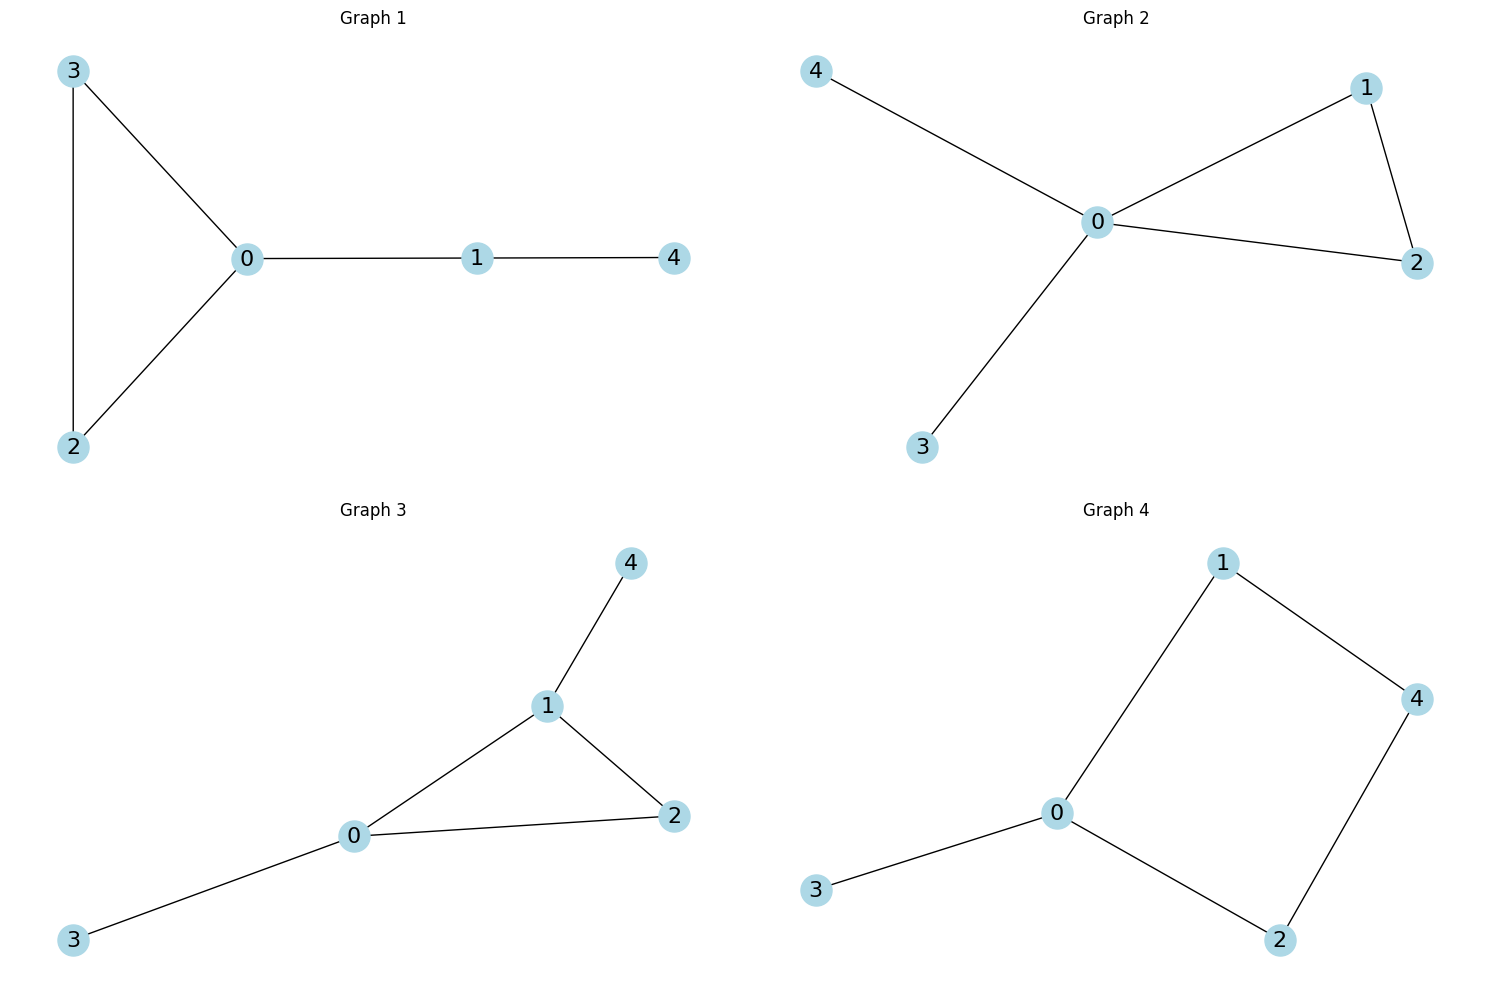

In [442]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

def generate_base_graph(num_nodes, allow_one_cycle=False):
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))

    # Ensure all nodes are connected
    for i in range(1, num_nodes):
        parent = random.randint(0, i-1)
        graph.add_edge(parent, i)

    # List all nodes with degree 2 or more
    nodes_with_degree_2 = [node for node in graph.nodes() if graph.degree(node) >= 2]
    # Select a random node with degree 2 or more
    node = random.choice(nodes_with_degree_2)

    # For any 2 degrees node, add an edge between the other 2 nodes that are connecting to it
    if allow_one_cycle:
        neighbors = list(graph.neighbors(node))
        # Selected randomly 2 numbers from the neighbors of the node
        a, b = random.sample(neighbors, 2)
        print(f"Adding edge between {a} and {b}")
        graph.add_edge(a, b)

    # print the nodes that form the cycle
    if allow_one_cycle:
        print("Cycle:")
        for cycle in nx.cycle_basis(graph):
            print(cycle)


    return graph

def generate_non_isomorphic_graphs(base_graph):
    non_isomorphic_graphs = [base_graph]
    edges = list(base_graph.edges())
    nodes = list(base_graph.nodes())
    
    # Generate all possible combinations of edges
    for r in range(len(edges), len(nodes)*(len(nodes)-1)//2 + 1):
        for new_edges in itertools.combinations(itertools.combinations(nodes, 2), r):
            new_graph = nx.Graph()
            new_graph.add_nodes_from(nodes)
            new_graph.add_edges_from(new_edges)
            
            # Check if the new graph is connected and non-isomorphic to existing graphs
            if nx.is_connected(new_graph) and all(not nx.is_isomorphic(new_graph, g) for g in non_isomorphic_graphs):
                non_isomorphic_graphs.append(new_graph)
    
    return non_isomorphic_graphs

def visualize_graph(graph, ax):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, ax=ax, with_labels=True, node_color='lightblue', node_size=500, font_size=16)

# Example usage
num_nodes = 5
allow_one_cycle = True

base_graph = generate_base_graph(num_nodes, allow_one_cycle)
result = generate_non_isomorphic_graphs(base_graph)

print(f"Generated {len(result)} non-isomorphic graphs from edge permutations")

# Visualize the first 4 graphs (or fewer if less than 4 are generated)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i in range(min(4, len(result))):
    visualize_graph(result[i], axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"Graph {i+1}")

plt.tight_layout()
plt.show()

# Verify that all graphs are non-isomorphic
for i in range(len(result)):
    for j in range(i+1, len(result)):
        if nx.is_isomorphic(result[i], result[j]):
            print(f"Error: Graphs {i} and {j} are isomorphic!")

[(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
4
Graph with 4 nodes and 4 edges
Graph with 4 nodes and 4 edges
Graph with 4 nodes and 5 edges
Graph with 4 nodes and 5 edges
Generated 0 non-isomorphic graphs


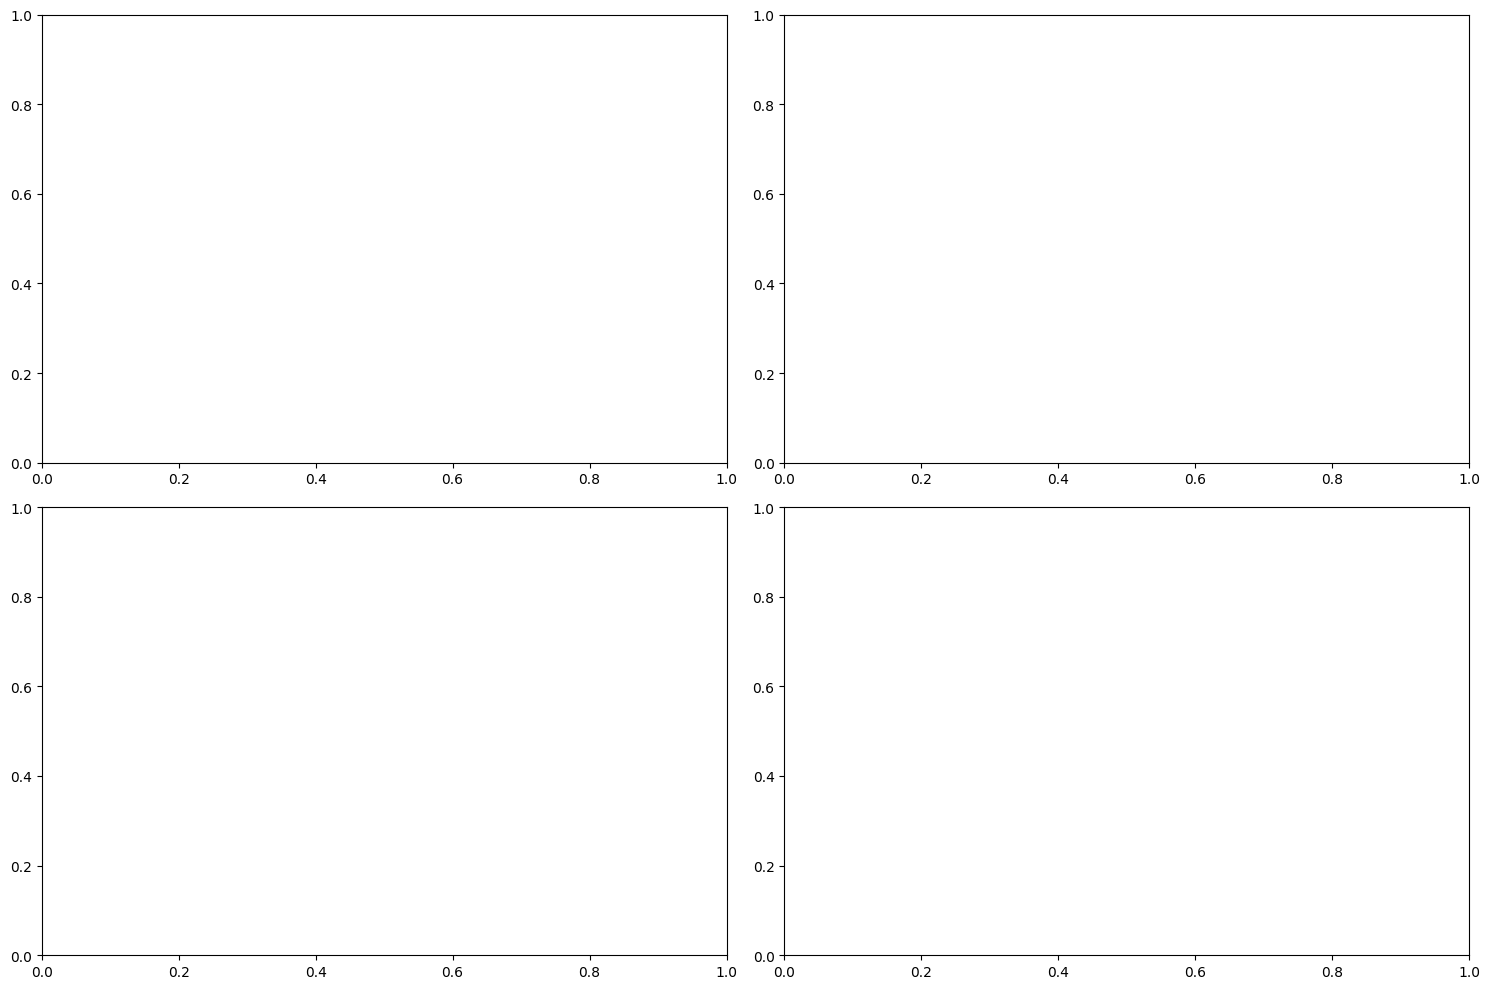

In [471]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import random

def generate_base_graph(num_nodes, allow_one_cycle=False):
    base_graphs = []
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))
    
    # Ensure all nodes are connected
    for i in range(1, num_nodes):
        parent = random.randint(0, i-1)
        graph.add_edge(parent, i)

    if allow_one_cycle:
        cycles = list(itertools.combinations(graph.nodes(), 3))
        print(cycles)
        for cycle in cycles:
            new_graph = nx.Graph()
            new_graph.add_nodes_from(graph.nodes())
            new_graph.add_edges_from(graph.edges())
            new_graph.add_edge(cycle[0], cycle[1])
            new_graph.add_edge(cycle[1], cycle[2])
            new_graph.add_edge(cycle[2], cycle[0])
            base_graphs.append(new_graph)
        print(len(base_graphs))
    else:
        base_graphs.append(graph)

    return base_graphs

def generate_non_isomorphic_graphs(base_graphs):
    non_isomorphic_graphs = []
    for base_graph in base_graphs:
        print(base_graph)
        aux_graphs = [base_graph]
        nodes = list(base_graph.nodes())
        base_edges = set(base_graph.edges())
        cycle = nx.cycle_basis(base_graph)[0] if nx.cycle_basis(base_graph) else []

        def is_valid_graph(g):
            return (nx.is_connected(g) and
                    set(nx.cycle_basis(g)[0]) == set(cycle) if cycle else True and
                    all(not nx.is_isomorphic(g, existing_g) for existing_g in aux_graphs))

        all_possible_edges = set(itertools.combinations(nodes, 2))
        non_cycle_edges = base_edges - set(zip(cycle, cycle[1:] + cycle[:1]))
        
        for r in range(len(non_cycle_edges), len(all_possible_edges) + 1):
            for new_edges in itertools.combinations(all_possible_edges - set(zip(cycle, cycle[1:] + cycle[:1])), r):
                new_graph = nx.Graph()
                new_graph.add_nodes_from(nodes)
                new_graph.add_edges_from(set(zip(cycle, cycle[1:] + cycle[:1])) | set(new_edges))
                
                if is_valid_graph(new_graph):
                    aux_graphs.append(new_graph)
        
        # Remove graphs with more than 1 cycle
        aux_graphs = [g for g in non_isomorphic_graphs if len(nx.cycle_basis(g)) <= 1]

        non_isomorphic_graphs.extend(aux_graphs)

    return non_isomorphic_graphs

def visualize_graph(graph, ax):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, ax=ax, with_labels=True, node_color='lightblue', node_size=500, font_size=16)

# Example usage
num_nodes = 4
allow_one_cycle = True

base_graph = generate_base_graph(num_nodes, allow_one_cycle)
result = generate_non_isomorphic_graphs(base_graph)

print(f"Generated {len(result)} non-isomorphic graphs")

# Visualize the first 4 graphs (or fewer if less than 4 are generated)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i in range(min(4, len(result))):
    visualize_graph(result[i], axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"Graph {i+1}")

plt.tight_layout()
plt.show()

# Verify that all graphs are non-isomorphic
for i in range(len(result)):
    for j in range(i+1, len(result)):
        if nx.is_isomorphic(result[i], result[j]):
            print(f"Error: Graphs {i} and {j} are isomorphic!")

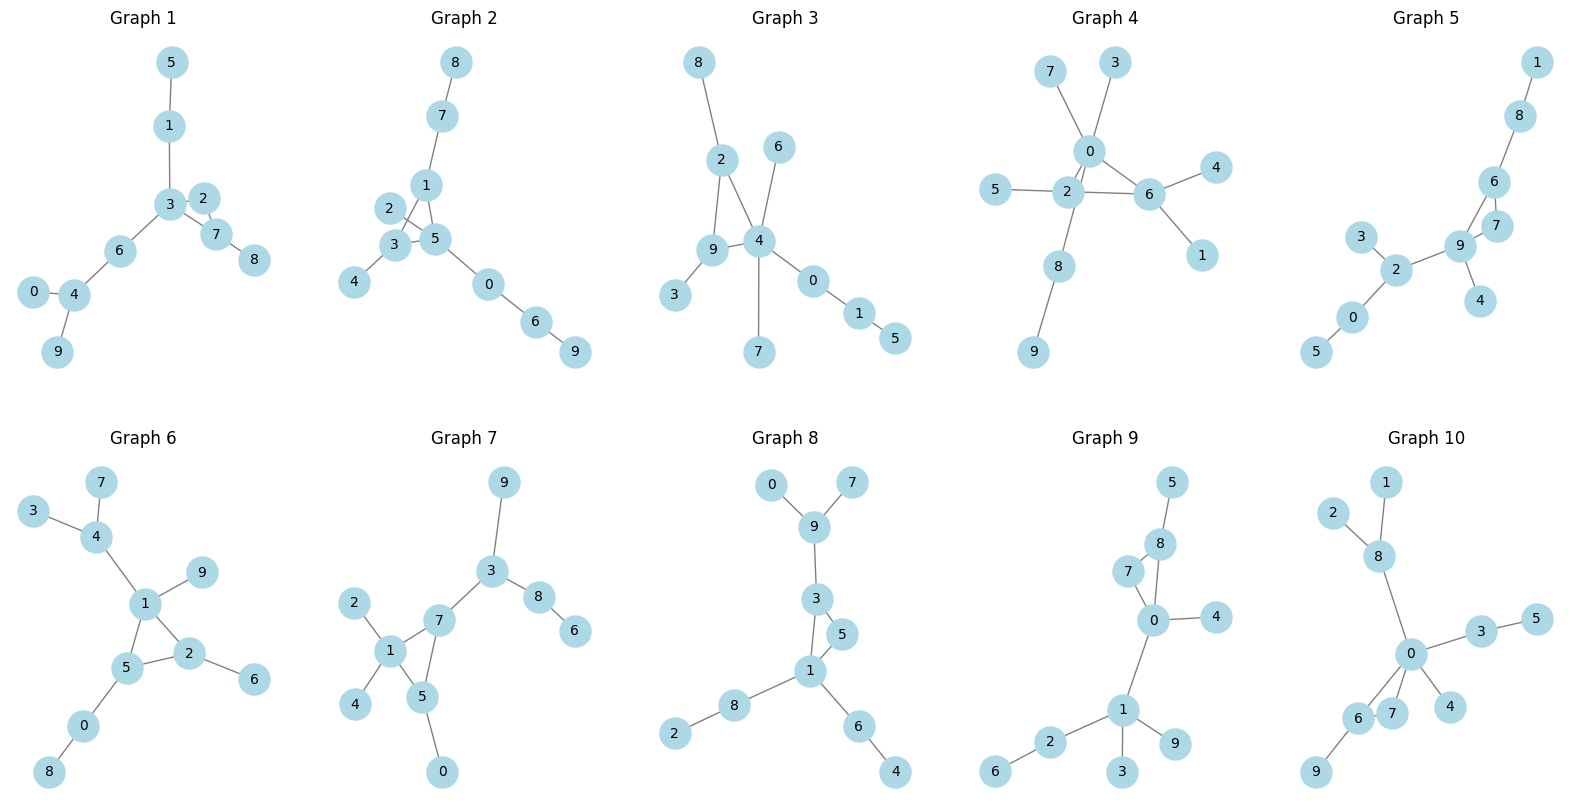

In [479]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def generate_non_isomorphic_graphs(num_nodes, allow_cycles):
    def add_triangle(graph, node_list):
        if len(node_list) < 3:
            raise ValueError("Not enough nodes to form a triangle")
        n1, n2, n3 = random.sample(node_list, 3)
        graph.add_edges_from([(n1, n2), (n2, n3), (n3, n1)])
    
    def generate_random_tree(n):
        tree = nx.random_tree(n)
        return tree
    
    def generate_random_graph_with_one_triangle(n):
        graph = nx.Graph()
        nodes = list(range(n))
        random.shuffle(nodes)
        
        # Add one triangle
        if n >= 3:
            add_triangle(graph, nodes[:3])
            remaining_nodes = nodes[3:]
        else:
            remaining_nodes = nodes
        
        # Add the remaining nodes
        for node in remaining_nodes:
            if len(graph.nodes) > 0:
                graph.add_edge(node, random.choice(list(graph.nodes)))
        
        return graph
    
    graphs = []
    if allow_cycles:
        for _ in range(100):  # Generate 100 different graphs to ensure non-isomorphism
            graphs.append(generate_random_graph_with_one_triangle(num_nodes))
    else:
        for _ in range(100):
            graphs.append(generate_random_tree(num_nodes))
    
    non_isomorphic_graphs = []
    for g in graphs:
        if all(not nx.is_isomorphic(g, existing_g) for existing_g in non_isomorphic_graphs):
            non_isomorphic_graphs.append(g)
    
    return non_isomorphic_graphs

def plot_graphs(graphs):
    plt.figure(figsize=(20, 10))
    for i, g in enumerate(graphs[:10]):
        plt.subplot(2, 5, i + 1)
        nx.draw(g, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
        plt.title(f'Graph {i + 1}')
    plt.show()

# Example usage
num_nodes = 10
allow_cycles = True
graphs = generate_non_isomorphic_graphs(num_nodes, allow_cycles)

plot_graphs(graphs[:10])  # Plot the first 10 non-isomorphic graphs


979


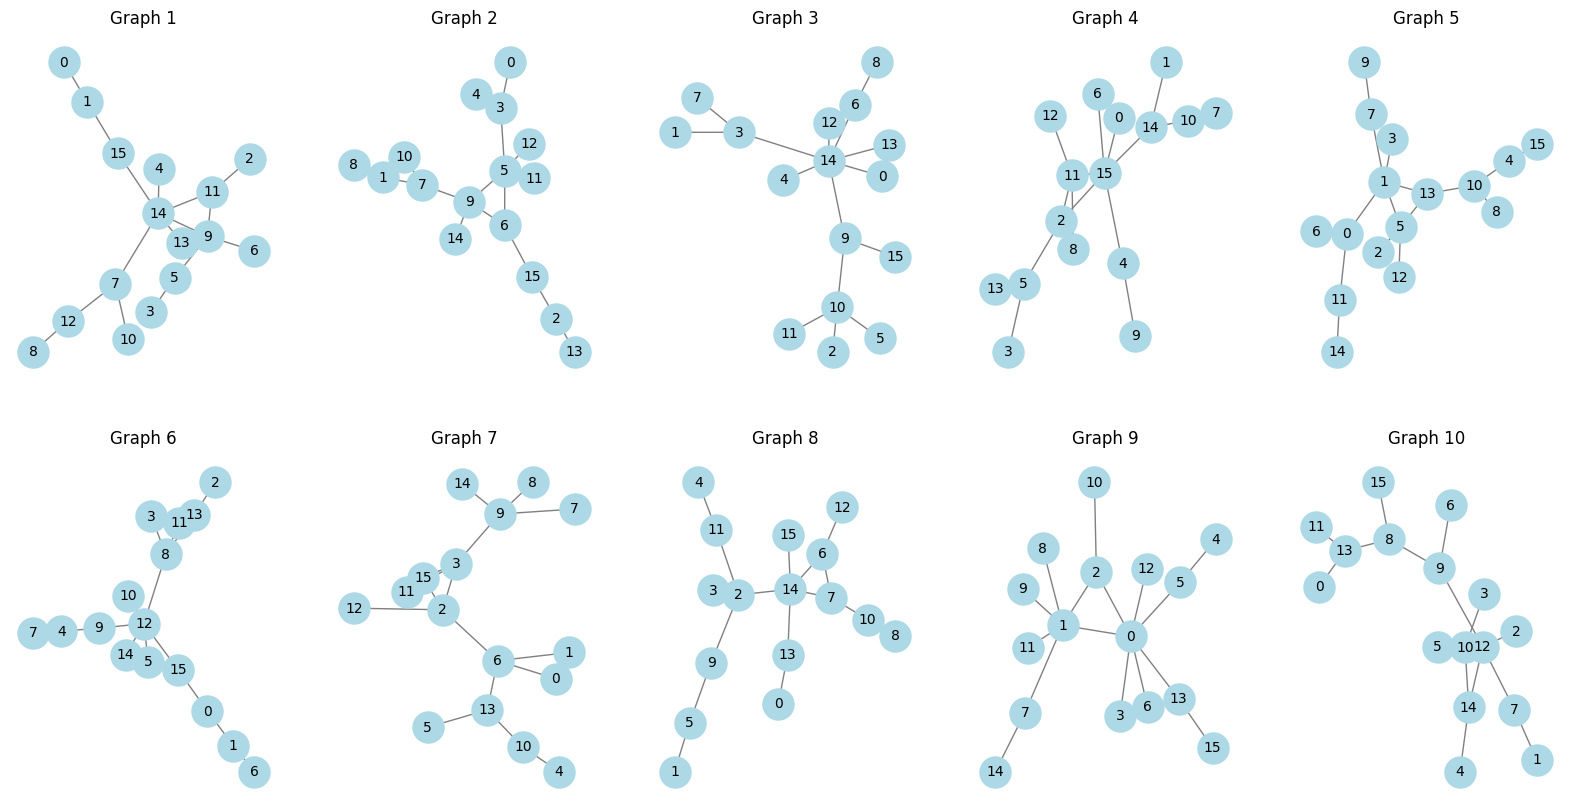

Node 0 is part of 19.00% of the total cycles.
Node 1 is part of 18.30% of the total cycles.
Node 2 is part of 19.20% of the total cycles.
Node 3 is part of 20.60% of the total cycles.
Node 4 is part of 17.70% of the total cycles.
Node 5 is part of 18.80% of the total cycles.
Node 6 is part of 17.90% of the total cycles.
Node 7 is part of 18.90% of the total cycles.
Node 8 is part of 17.40% of the total cycles.
Node 9 is part of 18.30% of the total cycles.
Node 10 is part of 19.10% of the total cycles.
Node 11 is part of 18.50% of the total cycles.
Node 12 is part of 19.70% of the total cycles.
Node 13 is part of 18.50% of the total cycles.
Node 14 is part of 19.20% of the total cycles.
Node 15 is part of 18.90% of the total cycles.


In [514]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict

def generate_non_isomorphic_graphs(num_nodes, allow_cycles):
    def add_triangle(graph, node_list):
        if len(node_list) < 3:
            raise ValueError("Not enough nodes to form a triangle")
        n1, n2, n3 = random.sample(node_list, 3)
        graph.add_edges_from([(n1, n2), (n2, n3), (n3, n1)])
        return {n1, n2, n3}
    
    def generate_random_tree(n):
        tree = nx.random_tree(n)
        return tree
    
    def generate_random_graph_with_one_triangle(n, node_participation):
        graph = nx.Graph()
        nodes = list(range(n))
        random.shuffle(nodes)
        
        # Add one triangle
        nodes_in_triangle = set()
        if n >= 3:
            nodes_in_triangle = add_triangle(graph, nodes[:3])
            for node in nodes_in_triangle:
                node_participation[node] += 1
            remaining_nodes = nodes[3:]
        else:
            remaining_nodes = nodes
        
        # Add the remaining nodes
        for node in remaining_nodes:
            if len(graph.nodes) > 0:
                graph.add_edge(node, random.choice(list(graph.nodes)))
        
        return graph
    
    graphs = []
    node_participation = defaultdict(int)
    if allow_cycles:
        for _ in range(1000):  # Generate 100 different graphs to ensure non-isomorphism
            graphs.append(generate_random_graph_with_one_triangle(num_nodes, node_participation))
    else:
        for _ in range(1000):
            graphs.append(generate_random_tree(num_nodes))
    
    non_isomorphic_graphs = []
    for g in graphs:
        if all(not nx.is_isomorphic(g, existing_g) for existing_g in non_isomorphic_graphs):
            non_isomorphic_graphs.append(g)
    print(len(non_isomorphic_graphs))
    return non_isomorphic_graphs, node_participation

def plot_graphs(graphs, node_participation, num_nodes, allow_cycles):
    plt.figure(figsize=(20, 10))
    for i, g in enumerate(graphs[:10]):
        plt.subplot(2, 5, i + 1)
        nx.draw(g, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
        plt.title(f'Graph {i + 1}')
    plt.show()
    
    if allow_cycles:
        total_cycles = sum(node_participation.values()) // 3  # Each cycle involves 3 nodes
        for node in range(num_nodes):
            percentage = (node_participation[node] / total_cycles) * 100
            print(f'Node {node} is part of {percentage:.2f}% of the total cycles.')

# Example usage
num_nodes = 16
allow_cycles = True
graphs, node_participation = generate_non_isomorphic_graphs(num_nodes, allow_cycles)

plot_graphs(graphs[:10], node_participation, num_nodes, allow_cycles)  # Plot the first 10 non-isomorphic graphs


In [533]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import numpy as np
from positional_encodings.torch_encodings import *

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pyvis.network import Network
from IPython.display import display, HTML

847
711


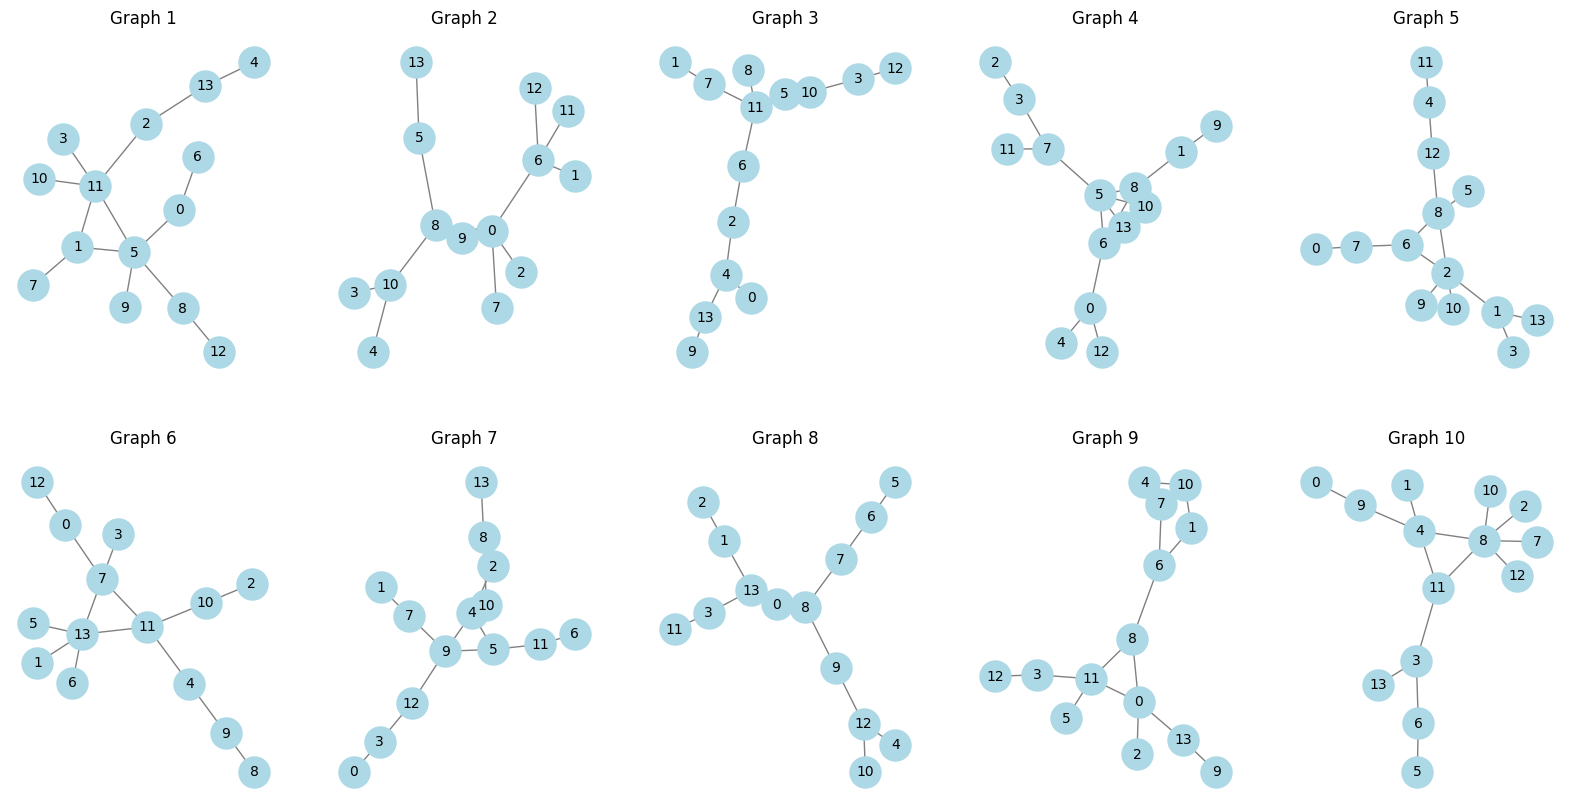

Node 0 is part of 22.00% of the total cycles.
Node 1 is part of 22.80% of the total cycles.
Node 2 is part of 20.20% of the total cycles.
Node 3 is part of 21.30% of the total cycles.
Node 4 is part of 22.40% of the total cycles.
Node 5 is part of 21.90% of the total cycles.
Node 6 is part of 20.40% of the total cycles.
Node 7 is part of 21.10% of the total cycles.
Node 8 is part of 21.80% of the total cycles.
Node 9 is part of 22.60% of the total cycles.
Node 10 is part of 20.80% of the total cycles.
Node 11 is part of 21.20% of the total cycles.
Node 12 is part of 19.10% of the total cycles.
Node 13 is part of 22.40% of the total cycles.


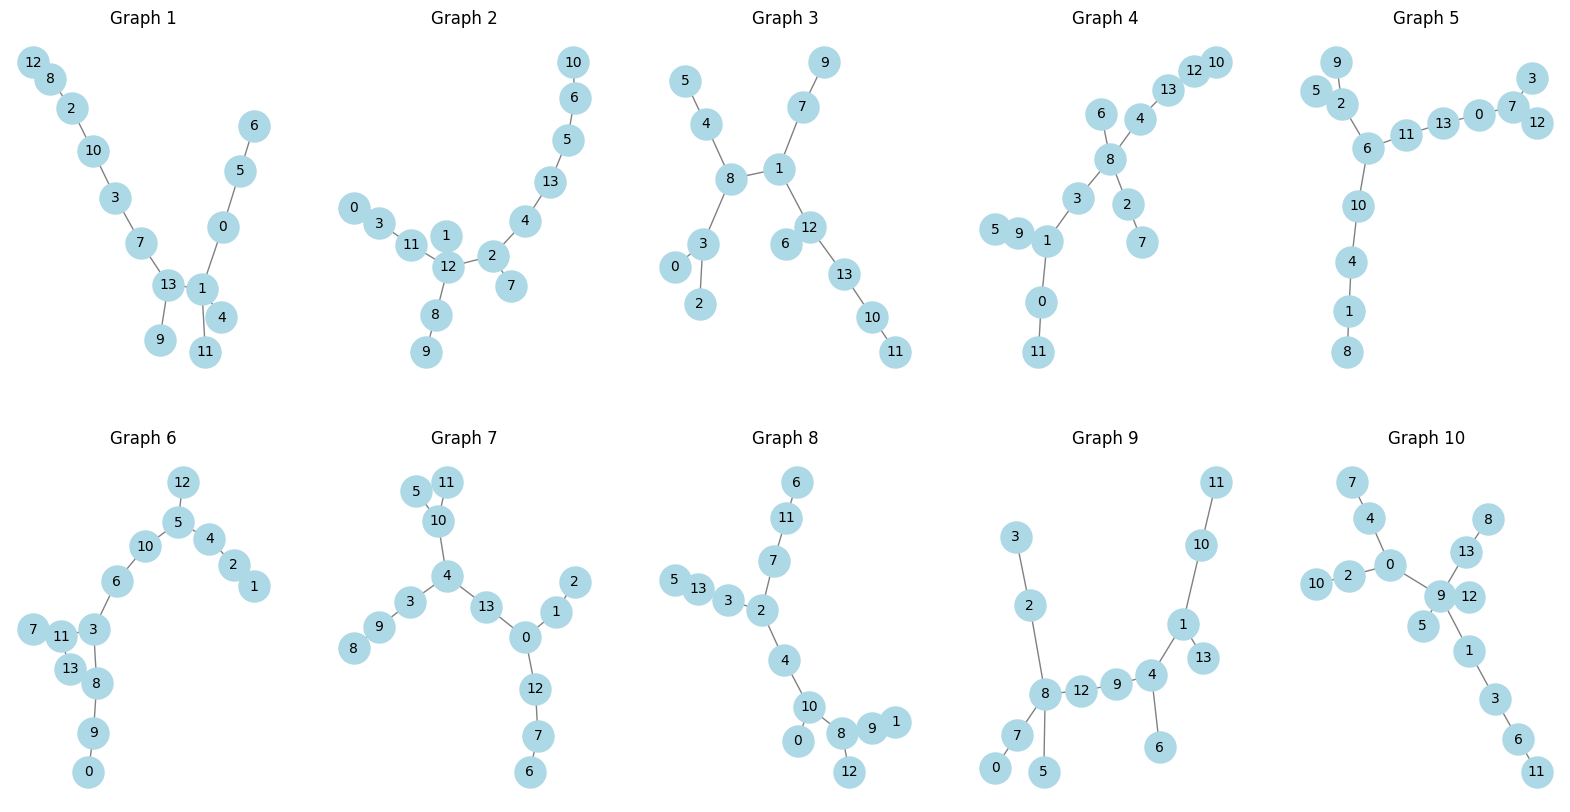

In [635]:
def generate_non_isomorphic_graphs(num_nodes, allow_cycles):
    def add_triangle(graph, node_list):
        if len(node_list) < 3:
            raise ValueError("Not enough nodes to form a triangle")
        n1, n2, n3 = random.sample(node_list, 3)
        graph.add_edges_from([(n1, n2), (n2, n3), (n3, n1)])
        return {n1, n2, n3}
    
    def generate_random_tree(n):
        tree = nx.random_tree(n)
        return tree
    
    def generate_random_graph_with_one_triangle(n, node_participation):
        graph = nx.Graph()
        nodes = list(range(n))
        random.shuffle(nodes)
        
        # Add one triangle
        nodes_in_triangle = set()
        if n >= 3:
            nodes_in_triangle = add_triangle(graph, nodes[:3])
            for node in nodes_in_triangle:
                node_participation[node] += 1
            remaining_nodes = nodes[3:]
        else:
            remaining_nodes = nodes
        
        # Add the remaining nodes
        for node in remaining_nodes:
            if len(graph.nodes) > 0:
                graph.add_edge(node, random.choice(list(graph.nodes)))
        
        return graph
    
    graphs = []
    node_participation = defaultdict(int)
    if allow_cycles:
        for _ in range(1000):  # Generate 1000 different graphs to ensure non-isomorphism
            graphs.append(generate_random_graph_with_one_triangle(num_nodes, node_participation))
    else:
        for _ in range(1000):
            graphs.append(generate_random_tree(num_nodes))
    
    non_isomorphic_graphs = []
    for g in graphs:
        if all(not nx.is_isomorphic(g, existing_g) for existing_g in non_isomorphic_graphs):
            non_isomorphic_graphs.append(g)
    print(len(non_isomorphic_graphs))
    return non_isomorphic_graphs, node_participation

def plot_graphs(graphs, node_participation, num_nodes, allow_cycles):
    plt.figure(figsize=(20, 10))
    for i, g in enumerate(graphs[:10]):
        plt.subplot(2, 5, i + 1)
        nx.draw(g, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
        plt.title(f'Graph {i + 1}')
    plt.show()
    
    if allow_cycles:
        total_cycles = sum(node_participation.values()) // 3  # Each cycle involves 3 nodes
        for node in range(num_nodes):
            percentage = (node_participation[node] / total_cycles) * 100
            print(f'Node {node} is part of {percentage:.2f}% of the total cycles.')

# Example usage
num_nodes = 14
allow_cycles = True
graphs_with_cycles, node_participation_with_cycles = generate_non_isomorphic_graphs(num_nodes, allow_cycles)
allow_cycles = False
graphs_without_cycles, node_participation_without_cycles = generate_non_isomorphic_graphs(num_nodes, allow_cycles)

plot_graphs(graphs_with_cycles[:10], node_participation_with_cycles, num_nodes, True)  # Plot the first 10 non-isomorphic graphs with cycles
plot_graphs(graphs_without_cycles[:10], node_participation_without_cycles, num_nodes, False)  # Plot the first 10 non-isomorphic graphs without cycles


In [610]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

In [611]:
def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

In [612]:
# Make adjacency matrix from the graphs with cycles and without cycles
adj_matrices_with_cycles = [nx.adjacency_matrix(g).toarray() for g in graphs_with_cycles]
adj_matrices_without_cycles = [nx.adjacency_matrix(g).toarray() for g in graphs_without_cycles]

# Combine the adjacency matrices into a single dataset
adj_matrices = np.array(adj_matrices_with_cycles + adj_matrices_without_cycles)
adj_matrices.shape

# Create a list with the values of the labels
labels = [1] * len(adj_matrices_with_cycles) + [0] * len(adj_matrices_without_cycles)
labels = np.array(labels)
labels


/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_92894/1987616192.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_with_cycles = [nx.adjacency_matrix(g).toarray() for g in graphs_with_cycles]
/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_92894/1987616192.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_without_cycles = [nx.adjacency_matrix(g).toarray() for g in graphs_without_cycles]


array([1, 1, 1, ..., 0, 0, 0])

In [613]:
# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

1600


In [614]:
# Check if train_loader and test_loader are different, they cant have the same graphs
for i, (train_batch, test_batch) in enumerate(zip(train_loader, test_loader)):
    train_adj, train_labels = train_batch
    test_adj, test_labels = test_batch
    if torch.equal(train_adj, test_adj) and torch.equal(train_labels, test_labels):
        print(f"Error: Train and Test batches {i} are the same!")

625
Epoch 1/50, Train Loss: 0.6226, Test Loss: 0.5215
Epoch 2/50, Train Loss: 0.4134, Test Loss: 0.3196
Epoch 3/50, Train Loss: 0.2391, Test Loss: 0.1806
Epoch 4/50, Train Loss: 0.1353, Test Loss: 0.1051
Epoch 5/50, Train Loss: 0.0823, Test Loss: 0.0667
Epoch 6/50, Train Loss: 0.0548, Test Loss: 0.0455
Epoch 7/50, Train Loss: 0.0392, Test Loss: 0.0334
Epoch 8/50, Train Loss: 0.0295, Test Loss: 0.0257
Epoch 9/50, Train Loss: 0.0231, Test Loss: 0.0202
Epoch 10/50, Train Loss: 0.0186, Test Loss: 0.0165
Epoch 11/50, Train Loss: 0.0154, Test Loss: 0.0137
Epoch 12/50, Train Loss: 0.0129, Test Loss: 0.0116
Epoch 13/50, Train Loss: 0.0110, Test Loss: 0.0100
Epoch 14/50, Train Loss: 0.0095, Test Loss: 0.0087
Epoch 15/50, Train Loss: 0.0083, Test Loss: 0.0076
Epoch 16/50, Train Loss: 0.0073, Test Loss: 0.0068
Epoch 17/50, Train Loss: 0.0064, Test Loss: 0.0061
Epoch 18/50, Train Loss: 0.0057, Test Loss: 0.0054
Epoch 19/50, Train Loss: 0.0052, Test Loss: 0.0049
Epoch 20/50, Train Loss: 0.0047, Tes

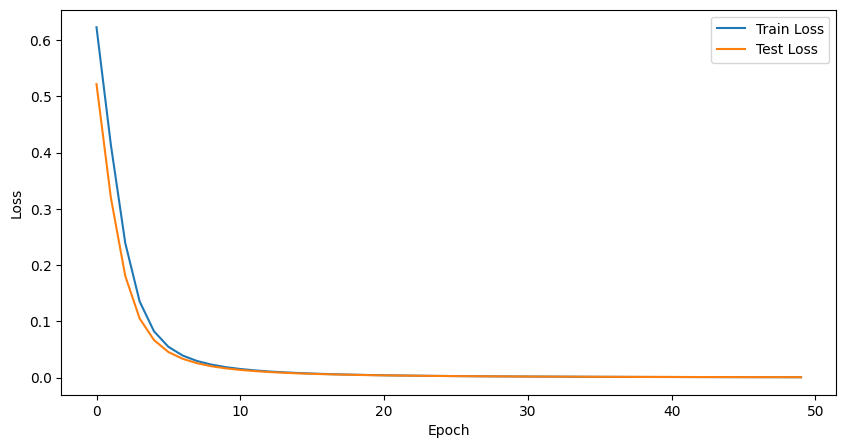

Accuracy: 1.00


In [615]:
# Generate an MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
# Initialize the model
input_size = adj_matrices.shape[1] * adj_matrices.shape[2]
hidden_size = 16
output_size = 1

model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
train_losses = []
test_losses = []
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj = adj.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(adj)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj = adj.view(-1, input_size)
            outputs = model(adj)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.show()

# Show accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj = adj.view(-1, input_size)
        outputs = model(adj)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

print(f'Accuracy: {correct / total:.2f}')


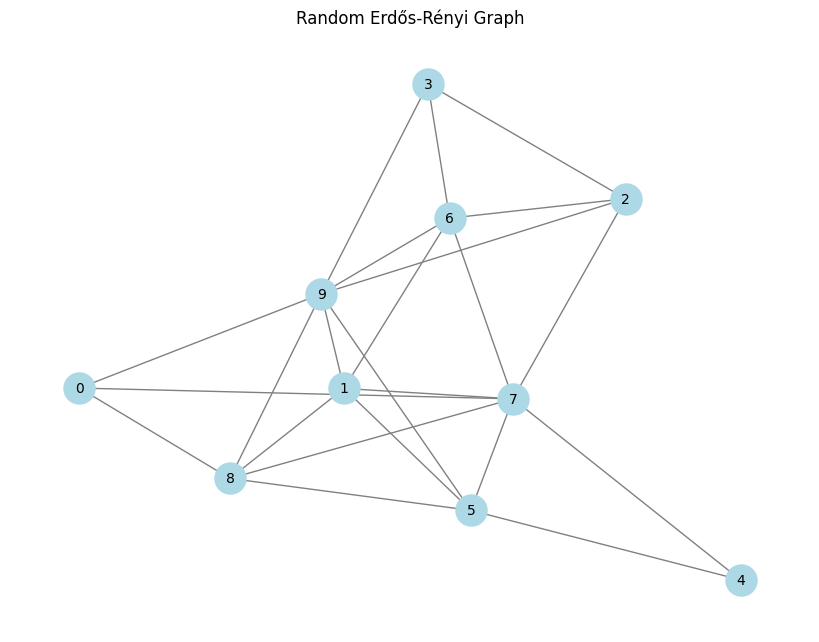

In [627]:
import networkx as nx
import random

def generate_erdos_renyi_graph(n, p):
    """
    Generate a random Erdős-Rényi graph G(n, p).

    Parameters:
    - n (int): Number of nodes in the graph.
    - p (float): Probability of edge creation between any pair of nodes.

    Returns:
    - G (networkx.Graph): A random Erdős-Rényi graph.
    """
    G = nx.erdos_renyi_graph(n, p)
    return G

# Example usage
num_nodes = 10
probability = 0.5
random_graph = generate_erdos_renyi_graph(num_nodes, probability)

# Plot the generated graph
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
nx.draw(random_graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title('Random Erdős-Rényi Graph')
plt.show()


Graphs with triangles: 500
Graphs without triangles: 500


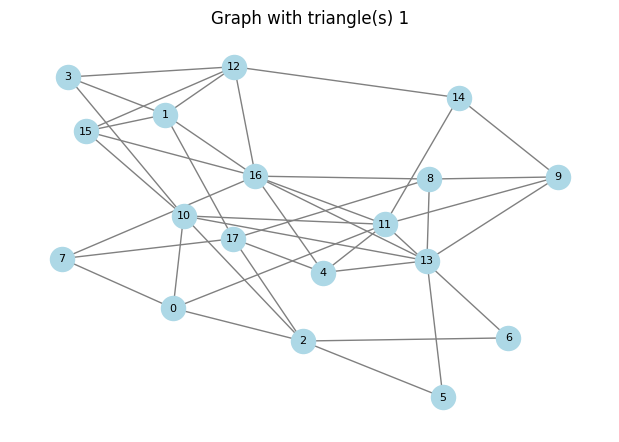

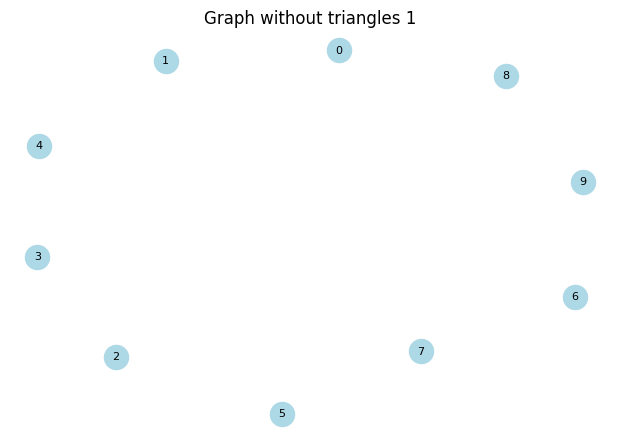

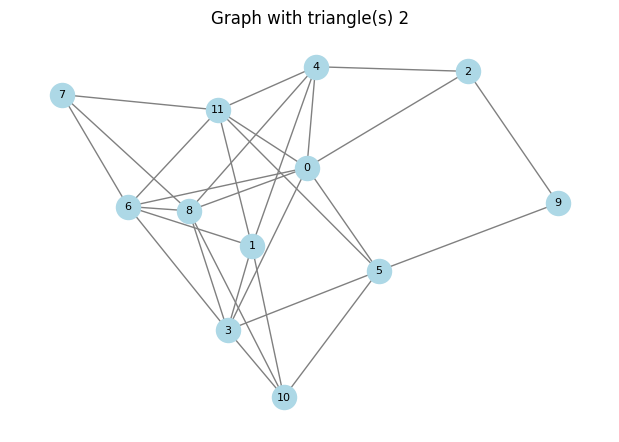

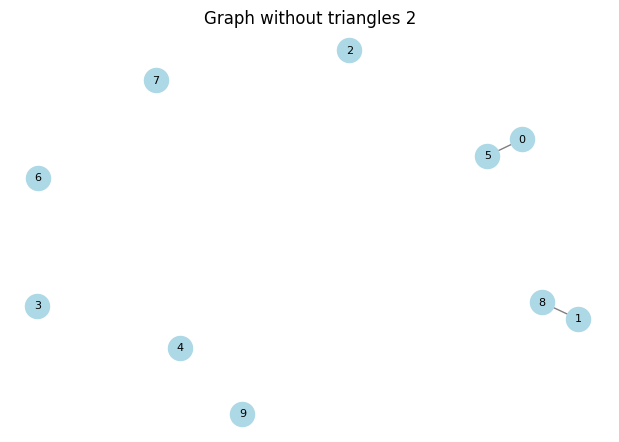


Statistics for graphs with triangles:
{'avg_nodes': 14.9, 'avg_edges': 33.088, 'min_nodes': 10, 'max_nodes': 20, 'min_edges': 3, 'max_edges': 96}

Statistics for graphs without triangles:
{'avg_nodes': 10.794, 'avg_edges': 2.372, 'min_nodes': 10, 'max_nodes': 15, 'min_edges': 0, 'max_edges': 6}


In [628]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def generate_erdos_renyi_graph(n, p):
    """
    Generate a random Erdős-Rényi graph G(n, p).

    Parameters:
    - n (int): Number of nodes in the graph.
    - p (float): Probability of edge creation between any pair of nodes.

    Returns:
    - G (networkx.Graph): A random Erdős-Rényi graph.
    """
    G = nx.erdos_renyi_graph(n, p)
    return G

def has_triangle(G):
    """
    Check if the graph contains at least one triangle.
    """
    return any(len(set(nbrs) & set(G[n])) >= 2 for n, nbrs in G.adj.items())

def generate_balanced_dataset(num_graphs, n_range, p_range):
    """
    Generate a balanced dataset of Erdős-Rényi graphs.

    Parameters:
    - num_graphs (int): Total number of graphs to generate.
    - n_range (tuple): Range of number of nodes (min, max).
    - p_range (tuple): Range of edge probability (min, max).

    Returns:
    - graphs_with_triangles (list): List of graphs with at least one triangle.
    - graphs_without_triangles (list): List of graphs without triangles.
    """
    graphs_with_triangles = []
    graphs_without_triangles = []
    
    while len(graphs_with_triangles) < num_graphs // 2 or len(graphs_without_triangles) < num_graphs // 2:
        n = random.randint(*n_range)
        p = random.uniform(*p_range)
        G = generate_erdos_renyi_graph(n, p)
        
        if has_triangle(G) and len(graphs_with_triangles) < num_graphs // 2:
            graphs_with_triangles.append(G)
        elif not has_triangle(G) and len(graphs_without_triangles) < num_graphs // 2:
            graphs_without_triangles.append(G)
    
    return graphs_with_triangles, graphs_without_triangles

# Generate the dataset
num_graphs = 1000  # Total number of graphs
n_range = (10, 20)  # Range for number of nodes
p_range = (0.1, 0.5)  # Range for edge probability

graphs_with_triangles, graphs_without_triangles = generate_balanced_dataset(num_graphs, n_range, p_range)

print(f"Graphs with triangles: {len(graphs_with_triangles)}")
print(f"Graphs without triangles: {len(graphs_without_triangles)}")

# Visualize a few examples
def plot_graph(G, title):
    plt.figure(figsize=(6, 4))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=8)
    plt.title(title)
    plt.show()

# Plot 2 graphs with triangles and 2 without
for i in range(2):
    plot_graph(graphs_with_triangles[i], f"Graph with triangle(s) {i+1}")
    plot_graph(graphs_without_triangles[i], f"Graph without triangles {i+1}")

# Additional statistics
def graph_stats(graphs):
    num_nodes = [G.number_of_nodes() for G in graphs]
    num_edges = [G.number_of_edges() for G in graphs]
    return {
        "avg_nodes": sum(num_nodes) / len(num_nodes),
        "avg_edges": sum(num_edges) / len(num_edges),
        "min_nodes": min(num_nodes),
        "max_nodes": max(num_nodes),
        "min_edges": min(num_edges),
        "max_edges": max(num_edges)
    }

print("\nStatistics for graphs with triangles:")
print(graph_stats(graphs_with_triangles))
print("\nStatistics for graphs without triangles:")
print(graph_stats(graphs_without_triangles))

In [630]:
import torch
from torch.utils.data import Dataset, DataLoader
import networkx as nx
import numpy as np

def pad_adj_matrix(matrix, size):
    """Pad adjacency matrix to the desired size."""
    padded_matrix = np.zeros((size, size))
    padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    return padded_matrix

class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
        
        # Determine the maximum size of the adjacency matrix
        self.max_size = max(max(g.number_of_nodes() for g in graphs), 1)
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        adj_matrix = nx.to_numpy_array(self.graphs[idx])
        padded_matrix = pad_adj_matrix(adj_matrix, self.max_size)
        return torch.FloatTensor(padded_matrix), torch.FloatTensor([self.labels[idx]])

def collate_fn(batch):
    """Custom collate function to handle variable-sized input."""
    adj_matrices, labels = zip(*batch)
    adj_matrices = torch.stack([torch.FloatTensor(m) for m in adj_matrices])
    labels = torch.stack(labels)
    return adj_matrices, labels

# Generate the dataset
num_graphs = 1000
n_range = (10, 20)
p_range = (0.1, 0.5)

graphs_with_triangles, graphs_without_triangles = generate_balanced_dataset(num_graphs, n_range, p_range)

# Prepare dataset
all_graphs = graphs_with_triangles + graphs_without_triangles
labels = [1] * len(graphs_with_triangles) + [0] * len(graphs_without_triangles)

# Shuffle the data
combined = list(zip(all_graphs, labels))
random.shuffle(combined)
all_graphs, labels = zip(*combined)

# Create PyTorch dataset
dataset = GraphDataset(all_graphs, labels)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders with custom collate function
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [631]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_heads=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, 64)
        self.pos_encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        pos = self.pos_encoder(torch.arange(x.size(1), device=x.device).unsqueeze(0).repeat(x.size(0), 1))
        x = x + pos.unsqueeze(2)
        x = x.permute(1, 0, 2)  # Change to (seq_len, batch_size, feature_dim)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Global average pooling
        return torch.sigmoid(self.fc(x))

# Initialize models
input_size = n_range[1] * n_range[1]  # Maximum possible input size
mlp_model = MLP(input_size)
transformer_model = TransformerModel(n_range[1])

# Define loss function and optimizer
mlp_criterion = nn.BCELoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

transformer_criterion = nn.BCELoss()
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)


/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
